In [302]:


import os
import math
import json
import random
import string
import textwrap
import hashlib
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from dataclasses import dataclass
from typing import List, Tuple, Dict

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

random.seed(42)
np.random.seed(42)

DATA_PATH = "spam.csv"


In [303]:

# ---------
# 1) Load dataset
# ---------
df = pd.read_csv(DATA_PATH, encoding="latin-1")
# Handle common UCI SMS spam CSV formats
# Try to infer label/text columns
possible_label_cols = [c for c in df.columns if "label" in c.lower() or c.lower() in {"class","v1"}]
possible_text_cols = [c for c in df.columns if "text" in c.lower() or c.lower() in {"message","sms","v2"}]

if not possible_label_cols or not possible_text_cols:
    # Fall back to first two columns if shape matches known UCI format
    if df.shape[1] >= 2:
        label_col, text_col = df.columns[0], df.columns[1]
    else:
        raise ValueError("Could not infer label/text columns from spam.csv. Please ensure it has label and text columns.")
else:
    label_col, text_col = possible_label_cols[0], possible_text_cols[0]

df = df[[label_col, text_col]].rename(columns={label_col:"label", text_col:"text"})
df["label"] = df["label"].astype(str).str.strip().str.lower()
df["text"] = df["text"].astype(str)

# Normalize labels to 'ham'/'spam'
label_map = {
    "ham":"ham","spam":"spam",
    "0":"ham","1":"spam",
    "h":"ham","s":"spam"
}
df["label"] = df["label"].map(lambda x: label_map.get(x, x))
df = df[df["label"].isin(["ham","spam"])].reset_index(drop=True)

print("Dataset shape:", df.shape)
print(df["label"].value_counts())


Dataset shape: (5572, 2)
label
ham     4825
spam     747
Name: count, dtype: int64


In [304]:

# ---------
# 2) Splits: train/val/test with stratification
#    Train NSA on ham-only from TRAIN split.
# ---------
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df["label"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"])

print("Train/Val/Test sizes:", len(train_df), len(val_df), len(test_df))
print("Train label counts:\n", train_df["label"].value_counts())


Train/Val/Test sizes: 3343 1114 1115
Train label counts:
 label
ham     2895
spam     448
Name: count, dtype: int64


In [305]:

# ---------------
# 3) Text -> Bitstring Encoding via hashed character n-grams (Bloom-like)
# ---------------

@dataclass
class EncodingConfig:
    bit_length: int = 2048          # L, total bits
    ngram_min: int = 3
    ngram_max: int = 3
    num_hashes: int = 2            # K independent hashes per n-gram
    normalize: bool = False        # If True, convert to 0/1 after threshold; here we'll use 0/1 directly

def normalize_text(s: str) -> str:
    s = s.lower()
    # keep letters, digits and spaces
    s = "".join(ch if ch.isalnum() or ch.isspace() else " " for ch in s)
    s = " ".join(s.split())
    return s

def ngrams(s: str, nmin: int, nmax: int):
    for n in range(nmin, nmax+1):
        for i in range(len(s)-n+1):
            yield s[i:i+n]

def stable_hash(x: str, seed: int) -> int:
    # Seeded hash: combine seed + x
    h = hashlib.blake2b((str(seed)+"|"+x).encode("utf-8"), digest_size=16).hexdigest()
    return int(h, 16)

def text_to_bitstring(s: str, cfg: EncodingConfig) -> np.ndarray:
    v = np.zeros(cfg.bit_length, dtype=np.uint8)
    s = normalize_text(s)
    for g in ngrams(s, cfg.ngram_min, cfg.ngram_max):
        for k in range(cfg.num_hashes):
            idx = stable_hash(g, seed=k) % cfg.bit_length
            v[idx] = 1
    return v

# Quick smoke test on encoding
enc_cfg = EncodingConfig(bit_length=2048, ngram_min=3, ngram_max=3, num_hashes=2)


In [306]:

# ---------------
# 4) Matching Rule: Hamming distance <= r
# ---------------
def hamming_distance(a: np.ndarray, b: np.ndarray) -> int:
    return int(np.sum(a != b))

def matches(a: np.ndarray, b: np.ndarray, radius: int) -> bool:
    return hamming_distance(a,b) <= radius


In [307]:

# ---------------
# 5) Negative Selection Algorithm (NSA)
#    - Generate random detectors (binary strings of length L)
#    - Reject any detector that matches ANY ham in train (under radius r)
#    - Keep until N detectors or attempts exhausted
# ---------------

@dataclass
class NSAConfig:
    bit_length: int
    radius: int                # Hamming match radius
    num_detectors: int         # Target number of detectors
    max_attempts: int = 200000 # Cap on random draws (avoid infinite loops)
    # For efficiency, we pre-encode self set (ham)
    
def random_bitstring_density_matched(L: int, p: float) -> np.ndarray:
    # Each bit is 1 with probability p (like ham encodings)
    return (np.random.rand(L) < p).astype(np.uint8)


def generate_detectors(ham_bitstrings, cfg, p_density=None, verbose=True):
    detectors = []
    attempts = 0
    ham_matrix = np.vstack(ham_bitstrings) if len(ham_bitstrings)>0 else np.zeros((0, cfg.bit_length), dtype=np.uint8)
    if p_density is None:
        p_density = float(ham_matrix.mean()) if ham_matrix.size>0 else 0.1  # fallback

    while len(detectors) < cfg.num_detectors and attempts < cfg.max_attempts:
        d = random_bitstring_density_matched(cfg.bit_length, p_density)
        if ham_matrix.size > 0:
            xor_mat = ham_matrix ^ d
            dists = np.sum(xor_mat, axis=1)
            if np.min(dists) <= cfg.radius:
                attempts += 1
                if verbose and attempts % 5000 == 0:
                    print(f"Attempts={attempts}, Detectors={len(detectors)} (rejections happening)")
                continue
        detectors.append(d)
        attempts += 1
        if verbose and attempts % 5000 == 0:
            print(f"Attempts={attempts}, Detectors={len(detectors)}")
    if verbose:
        print(f"Finished: attempts={attempts}, detectors_kept={len(detectors)}")
    return detectors


In [308]:

# ---------------
# 6) Scoring / Inference with NSA
#    Score = number of detectors that match (distance <= r). Threshold t=1 for binary,
#    but we keep the raw count for PR curves.
# ---------------

def nsa_score(message_bit: np.ndarray, detectors: List[np.ndarray], radius: int) -> int:
    if not detectors:
        return 0
    D = np.vstack(detectors)  # [D, L]
    xor_mat = D ^ message_bit
    dists = np.sum(xor_mat, axis=1)
    return int(np.sum(dists <= radius))

def nsa_predict(messages_bits: List[np.ndarray], detectors: List[np.ndarray], radius: int, threshold: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    scores = np.array([nsa_score(mb, detectors, radius) for mb in messages_bits])
    y_pred = (scores >= threshold).astype(int)  # 1=spam, 0=ham
    return y_pred, scores


In [309]:

# ---------------
# 7) Prepare data encodings
# ---------------
train_ham = train_df[train_df["label"]=="ham"].copy()
train_spam = train_df[train_df["label"]=="spam"].copy()
val_all = val_df.copy()
test_all = test_df.copy()

# Encode texts
train_ham_bits = [text_to_bitstring(t, enc_cfg) for t in train_ham["text"]]
train_spam_bits = [text_to_bitstring(t, enc_cfg) for t in train_spam["text"]]
val_bits = [text_to_bitstring(t, enc_cfg) for t in val_all["text"]]
test_bits = [text_to_bitstring(t, enc_cfg) for t in test_all["text"]]

# After you build train_ham_bits
ham_matrix = np.vstack(train_ham_bits)  # [H, L]
# Global bit density (fraction of 1s across all bits/messages)
ham_density = float(ham_matrix.mean())
print("Estimated ham bit density:", ham_density)


Estimated ham bit density: 0.05428692384499136


In [310]:

# 8) NSA detector training + tiny radius sweep (simple)
# ----------------------------------------------------
def stats_from_density(bit_length, p):
    q = 2*p*(1-p)
    mu = q * bit_length
    sd = np.sqrt(bit_length * q * (1 - q))
    return q, mu, sd

q, mu, sd = stats_from_density(enc_cfg.bit_length, ham_density)
print(f"p={ham_density:.4f}, q={q:.4f}, mu≈{mu:.1f}, sd≈{sd:.1f}")

# Try a few mid-range radii; 80 was too small (no spam hits), 173 was too big (all rejections).
# These values are a good, quick sweep for your current density:
r_list = [100, 120, 140, 160]

def train_detectors_for_radius(r, num_det=800, attempts=200_000):
    cfg = NSAConfig(bit_length=enc_cfg.bit_length, radius=r,
                    num_detectors=num_det, max_attempts=attempts)
    dets = generate_detectors(train_ham_bits, cfg, p_density=ham_density, verbose=True)
    return dets

def quick_val_stats(dets, r):
    if len(dets) == 0:
        return {"max_score":0, "avg_spam":0.0, "avg_ham":0.0, "f1":0.0, "p":0.0, "r":0.0}
    scores = np.array([nsa_score(b, dets, r) for b in val_bits])
    yv = (val_all["label"].values == "spam").astype(int)

    max_sc = int(scores.max()) if len(scores)>0 else 0
    avg_spam = float(scores[yv==1].mean()) if (yv==1).any() else 0.0
    avg_ham  = float(scores[yv==0].mean()) if (yv==0).any() else 0.0

    best = {"f1":-1, "p":0.0, "r":0.0}
    for thr in range(1, max(2, max_sc+1)):
        yhat = (scores >= thr).astype(int)
        p_, r_, f1_, _ = precision_recall_fscore_support(yv, yhat, average="binary", zero_division=0)
        if f1_ > best["f1"]:
            best = {"f1":float(f1_), "p":float(p_), "r":float(r_)}

    return {"max_score":max_sc, "avg_spam":avg_spam, "avg_ham":avg_ham, **best}

trial_results = []
best_tuple = None

for r in r_list:
    print(f"\n=== Training detectors at radius={r} ===")
    dets = train_detectors_for_radius(r, num_det=800, attempts=200_000)
    stats = quick_val_stats(dets, r)
    print(f"[r={r}] kept={len(dets)}  max_score={stats['max_score']}  "
          f"avg_spam={stats['avg_spam']:.3f}  avg_ham={stats['avg_ham']:.3f}  "
          f"F1={stats['f1']:.3f} (P={stats['p']:.3f}, R={stats['r']:.3f})")
    trial_results.append((r, len(dets), stats, dets))
    # pick if it shows real signal
    if stats["max_score"]>=1 and stats["avg_spam"]>stats["avg_ham"] and stats["f1"]>0:
        best_tuple = (r, len(dets), stats, dets)
        break  # stop early once we have something usable

# fallback: pick the one with the highest max_score, then by (avg_spam - avg_ham)
if best_tuple is None:
    best_tuple = max(trial_results, key=lambda t: (t[2]["max_score"], t[2]["avg_spam"] - t[2]["avg_ham"]))

radius, kept, stats, detectors = best_tuple
print(f"\nChosen radius={radius}  kept={kept}  "
      f"max_score={stats['max_score']}  avg_spam={stats['avg_spam']:.3f}  "
      f"avg_ham={stats['avg_ham']:.3f}  F1={stats['f1']:.3f}")

# OPTIONAL: scale up to 1200–1600 once you have signal
if len(detectors) < 1200:
    cfg_more = NSAConfig(bit_length=enc_cfg.bit_length, radius=radius, num_detectors=1200, max_attempts=400_000)
    detectors = generate_detectors(train_ham_bits, cfg_more, p_density=ham_density, verbose=True)
    print(f"Scaled to detectors_kept={len(detectors)} at radius={radius}")


p=0.0543, q=0.1027, mu≈210.3, sd≈13.7

=== Training detectors at radius=100 ===
Finished: attempts=947, detectors_kept=800
[r=100] kept=800  max_score=1  avg_spam=0.000  avg_ham=0.002  F1=0.000 (P=0.000, R=0.000)

=== Training detectors at radius=120 ===
Finished: attempts=4414, detectors_kept=800
[r=120] kept=800  max_score=2  avg_spam=0.000  avg_ham=0.002  F1=0.000 (P=0.000, R=0.000)

=== Training detectors at radius=140 ===
Attempts=5000, Detectors=14 (rejections happening)
Attempts=10000, Detectors=28 (rejections happening)
Attempts=15000, Detectors=47 (rejections happening)
Attempts=20000, Detectors=65 (rejections happening)
Attempts=25000, Detectors=78 (rejections happening)
Attempts=30000, Detectors=95 (rejections happening)
Attempts=35000, Detectors=102 (rejections happening)
Attempts=40000, Detectors=109 (rejections happening)
Attempts=45000, Detectors=132 (rejections happening)
Attempts=50000, Detectors=139 (rejections happening)
Attempts=55000, Detectors=148 (rejections happ

In [311]:
# After detectors are built:
val_match_counts = np.array([nsa_score(b, detectors, radius) for b in val_bits])
y_val_true = (val_all["label"].values == "spam").astype(int)

print("max score on val:", val_match_counts.max())
print("avg matches per spam (val):", val_match_counts[y_val_true==1].mean() if (y_val_true==1).any() else 0.0)
print("avg matches per ham  (val):", val_match_counts[y_val_true==0].mean() if (y_val_true==0).any() else 0.0)


max score on val: 2
avg matches per spam (val): 0.0
avg matches per ham  (val): 0.0031088082901554403


In [312]:

# ---------------
# 9) Validation: choose threshold for scores -> best F1 on spam
# ---------------
y_val_true = (val_all["label"].values == "spam").astype(int)

y_val_pred_bin, val_scores = nsa_predict(val_bits, detectors, radius=radius, threshold=1)

# Try multiple thresholds from 1 to max score
best = {"threshold":1, "f1":-1, "p":0,"r":0}
max_score = int(val_scores.max()) if len(val_scores)>0 else 1
for thr in range(1, max(2, max_score+1)):
    y_pred, _ = nsa_predict(val_bits, detectors, radius=radius, threshold=thr)
    p,r,f1,_ = precision_recall_fscore_support(y_val_true, y_pred, average="binary", zero_division=0)
    if f1 > best["f1"]:
        best = {"threshold":thr, "f1":f1, "p":p, "r":r}

print("Validation best threshold:", best)


Validation best threshold: {'threshold': 1, 'f1': 0.0, 'p': 0.0, 'r': 0.0}


In [313]:

# ---------------
# 10) Evaluate on Test
# ---------------
y_test_true = (test_all["label"].values == "spam").astype(int)
y_test_pred, test_scores = nsa_predict(test_bits, detectors, radius=radius, threshold=best["threshold"])

cm = confusion_matrix(y_test_true, y_test_pred)
p,r,f1,_ = precision_recall_fscore_support(y_test_true, y_test_pred, average="binary", zero_division=0)

print("Confusion matrix (Test) [[TN, FP],[FN, TP]]:\n", cm)
print("Precision/Recall/F1 (spam=positive):", p, r, f1)

# ROC-AUC and PR-AUC using scores (counts). Higher count => more spam-like.
try:
    roc_auc = roc_auc_score(y_test_true, test_scores)
except Exception:
    roc_auc = float("nan")
try:
    pr_auc = average_precision_score(y_test_true, test_scores)
except Exception:
    pr_auc = float("nan")

print("ROC-AUC:", roc_auc, "PR-AUC:", pr_auc)


Confusion matrix (Test) [[TN, FP],[FN, TP]]:
 [[964   1]
 [150   0]]
Precision/Recall/F1 (spam=positive): 0.0 0.0 0.0
ROC-AUC: 0.49948186528497407 PR-AUC: 0.13452914798206278


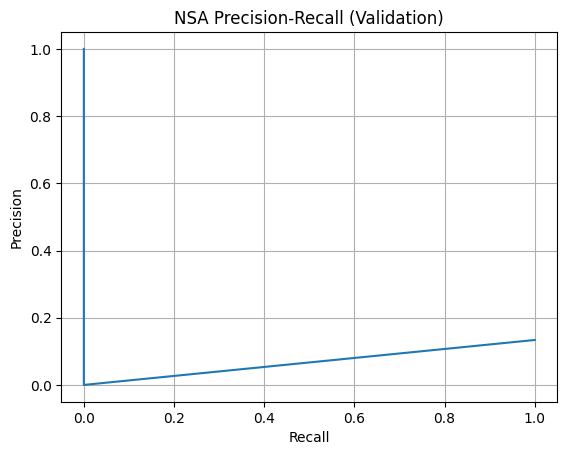

In [314]:

# ---------------
# 11) Plot: Precision-Recall curve on Validation (spam positive)
# ---------------
prec, reca, thrs = precision_recall_curve(y_val_true, val_scores)
plt.figure()
plt.plot(reca, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("NSA Precision-Recall (Validation)")
plt.grid(True)
plt.show()


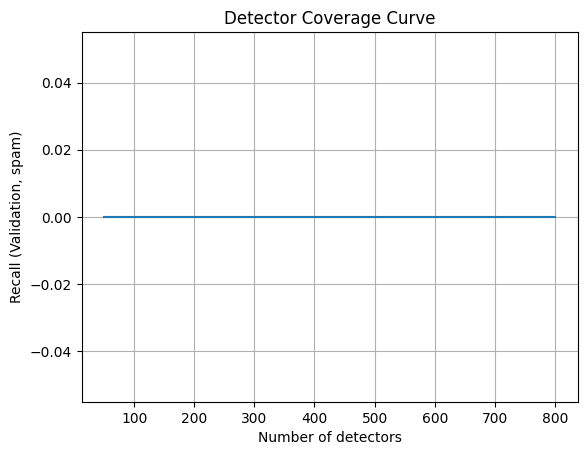

In [315]:

# ---------------
# 12) Detector coverage curve: Recall vs number of detectors (on validation)
# ---------------
def coverage_curve(val_bits, y_true, base_detectors: List[np.ndarray], radius: int, steps: List[int]):
    recs = []
    for n in steps:
        sub_det = base_detectors[:min(n, len(base_detectors))]
        if len(sub_det)==0:
            recs.append(0.0)
            continue
        y_pred, _ = nsa_predict(val_bits, sub_det, radius=radius, threshold=1)
        p_, r_, f1_, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
        recs.append(r_)
    return recs

steps = list(range(50, min(len(detectors), 800)+1, 50))
cover_recalls = coverage_curve(val_bits, y_val_true, detectors, radius, steps)

plt.figure()
plt.plot(steps, cover_recalls)
plt.xlabel("Number of detectors")
plt.ylabel("Recall (Validation, spam)")
plt.title("Detector Coverage Curve")
plt.grid(True)
plt.show()


Baseline LogReg best thr (val): {'thr': 0.30000000000000004, 'f1': 0.9257950530035336, 'p': 0.9776119402985075, 'r': 0.8791946308724832}
Baseline Confusion (Test):
 [[964   1]
 [ 11 139]]
Baseline Precision/Recall/F1 (Test): 0.9928571428571429 0.9266666666666666 0.9586206896551724
Baseline ROC-AUC/PR-AUC (Test): 0.9957167530224524 0.9845503556965353


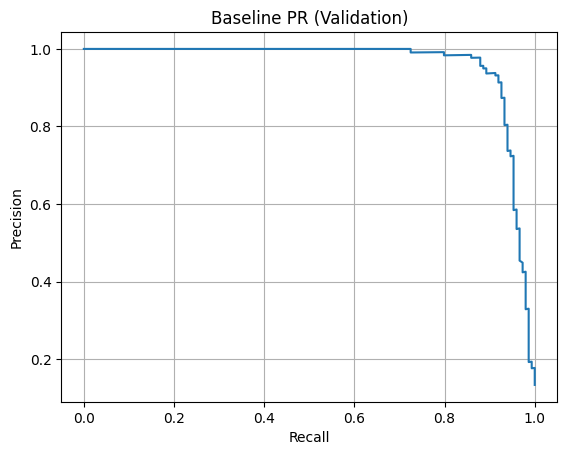

In [316]:

# ---------------
# 13) Baseline: TF-IDF + Logistic Regression
# ---------------
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
X_train = tfidf.fit_transform(train_df["text"])
X_val = tfidf.transform(val_df["text"])
X_test = tfidf.transform(test_df["text"])

y_train = (train_df["label"]=="spam").astype(int).values
y_val = (val_df["label"]=="spam").astype(int).values
y_test = (test_df["label"]=="spam").astype(int).values

logreg = LogisticRegression(max_iter=200, n_jobs=None)
logreg.fit(X_train, y_train)

val_proba = logreg.predict_proba(X_val)[:,1]
test_proba = logreg.predict_proba(X_test)[:,1]

# Choose threshold for best F1 on validation
best_bl = {"thr":0.5, "f1":-1, "p":0, "r":0}
for thr in np.linspace(0.1,0.9,17):
    y_pred = (val_proba >= thr).astype(int)
    p_, r_, f1_, _ = precision_recall_fscore_support(y_val, y_pred, average="binary", zero_division=0)
    if f1_ > best_bl["f1"]:
        best_bl = {"thr":float(thr), "f1":f1_, "p":p_, "r":r_}

y_test_pred_bl = (test_proba >= best_bl["thr"]).astype(int)
cm_bl = confusion_matrix(y_test, y_test_pred_bl)
p_bl, r_bl, f1_bl, _ = precision_recall_fscore_support(y_test, y_test_pred_bl, average="binary", zero_division=0)
roc_auc_bl = roc_auc_score(y_test, test_proba)
pr_auc_bl = average_precision_score(y_test, test_proba)

print("Baseline LogReg best thr (val):", best_bl)
print("Baseline Confusion (Test):\n", cm_bl)
print("Baseline Precision/Recall/F1 (Test):", p_bl, r_bl, f1_bl)
print("Baseline ROC-AUC/PR-AUC (Test):", roc_auc_bl, pr_auc_bl)

# Plot PR (baseline, validation)
prec_bl, reca_bl, _ = precision_recall_curve(y_val, val_proba)
plt.figure()
plt.plot(reca_bl, prec_bl)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Baseline PR (Validation)")
plt.grid(True)
plt.show()
